# Package Loading

In [ ]:
# ...:: NEEDED PACKAGE ::...

import os
import pandas as pd
# import glob
# import shutil
import numpy as np
import matplotlib.pyplot as plt
from time import time

# from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# import pickle
from tensorflow.keras.callbacks import EarlyStopping

# Prerequisites before execution

In [ ]:
# Just in case of unmounted Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ...:: PARAMETERS : FILL THEN RUN ALL :::...
# ...:: PATH SECTION

# Define the target directory path of the previous computed dataset
datasetDir = '/content/drive/My Drive/Colab Notebooks/FullStackProjectDeliverable/datasets/'
# Define the target directory path for saving the best val_mean_io_u weights during the fit
checkpointFilepath = '/content/drive/My Drive/Colab Notebooks/FullStackProjectDeliverable/checkpoint/unet_model_multilabels_256_meaniou/'
# Define the target directory path for model saving
modelDir = '/content/drive/My Drive/Colab Notebooks/FullStackProjectDeliverable/models/'

# ...:: NAME SECTION : DO NOT TOUCH IS BETTER
# Define the model name used for saving
modelName = 'unet_model_multilabels_256_meaniou.keras'
# Define the dataset name used for this compute and fit
datasetName = 'multiple_256_tag_float32'


# ...:: MODEL PARAMETERS

BATCH_SIZE = 32
BUFFER_SIZE = 1000
LEARNING_RATE = 0.0001
NUM_EPOCHS = 30
# VAL_SUBSPLITS is used in order to reduce validation steps. This is a way to reduce RAM used at each end epoch validation RAM uprising
VAL_SUBSPLITS = 5

# ...:: MODEL EARLY STOPPING
# !!! WARNING : MONITOR VARIABLE NAMES ARE CORRECT FOR THE FIRST FIT ITERATION IN A SESSION, ON THE SECOND, val_mean_io_u will be named val_mean_io_u_1
early_stopping_loss = EarlyStopping(monitor='loss', patience=4, mode='min')
early_stopping_iou = EarlyStopping(monitor='mean_io_u', patience=4, mode='max')
early_stopping_val_loss = EarlyStopping(monitor='val_loss', patience=4, mode='min')
early_stopping_val_iou = EarlyStopping(monitor='val_mean_io_u', patience=6, mode='max')
model_checkpoint_val_iou = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpointFilepath,
    save_weights_only=True,
    monitor='val_mean_io_u',
    mode='max',
    save_best_only=True)

In [ ]:
# Creation of the needed directory if they not exist

if not os.path.exists(checkpointFilepath):
    os.makedirs(checkpointFilepath)
if not os.path.exists(modelDir):
    os.makedirs(modelDir)

# Dataset Preparation

In [ ]:
# DATASET LOAD
dataset = tf.data.Dataset.load(os.path.join(datasetDir, datasetName))

# DATASET PARTITIONING INTO TRAIN AND TEST : A SEED APPROACH BECAUSE Cross Validation is RAM greedy

# shuffle_size as half around of images number for a better split without surrounding RAM
def get_dataset_partitions_tf(ds, ds_size, train_split=0.75, test_split=0.25, shuffle=True, shuffle_size=2500):
    assert (train_split + test_split ) == 1

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=32) # Specify seed to always have the same split distribution between runs.allows to compare parameters and dataset

    train_size = int(train_split * ds_size)
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)

    return train_ds, test_ds

train_dataset, test_dataset = get_dataset_partitions_tf(dataset, len(list(dataset)))

train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(1).batch(BATCH_SIZE)
test_batches = test_dataset.skip(1).take(len(test_dataset)-1).batch(BATCH_SIZE)

In [ ]:
# FOR CONTROL ONLY

# print("Len Train :", len(train_dataset))
# print("Len Test :", len(test_dataset))

# Model Build And Compile

In [ ]:
# ... FONCTION SECTION ::...

def double_conv_block(x, n_filters):
   # 2 Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 4, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 4, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 4, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

def build_unet_model():
   inputs = layers.Input(shape=(256,256,1))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(4, (1, 1), padding="same", activation = "softmax")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

@keras.saving.register_keras_serializable(package="MyLayers")
class CustomLayer(keras.layers.Layer):
    def __init__(self, factor):
        super().__init__()
        self.factor = factor

    def call(self, x):
        return x * self.factor

    def get_config(self):
        return {"factor": self.factor}

@keras.saving.register_keras_serializable(package="my_package", name="dice_loss")
def dice_loss(y_true, y_pred):
    # Convert y_true to float32 to match y_pred
    y_true = tf.cast(y_true, tf.float32)
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)

# ... EXECUTE SECTION ::...

# Adam optimizer function overloaded with learning rate
adamizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)


unet_model = build_unet_model()

unet_model.compile(optimizer=adamizer,
                  loss=dice_loss,
                  metrics=[tf.keras.metrics.MeanIoU(num_classes=4)])

# Model Fit

In [ ]:
start = time()

TRAIN_LENGTH = len(train_dataset)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

TEST_LENGTH = int(len(test_dataset) - 1)
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches,
                              callbacks=[early_stopping_loss, early_stopping_iou, early_stopping_val_loss, early_stopping_val_iou, model_checkpoint_val_iou])

# Elapsed fitting time display
print("Full fiting time :", (time() - start) / 60, " m")

Epoch 1/4
9/9 [==============================] - 58s 2s/step - loss: 0.4969 - mean_io_u: 0.4233 - val_loss: 0.5066 - val_mean_io_u: 0.4043
Epoch 2/4
9/9 [==============================] - 41s 2s/step - loss: 0.4853 - mean_io_u: 0.4057 - val_loss: 0.4398 - val_mean_io_u: 0.4570
Epoch 3/4
9/9 [==============================] - 12s 1s/step - loss: 0.4980 - mean_io_u: 0.3928 - val_loss: 0.4643 - val_mean_io_u: 0.4405
Epoch 4/4
9/9 [==============================] - 16s 2s/step - loss: 0.4943 - mean_io_u: 0.3972 - val_loss: 0.4335 - val_mean_io_u: 0.4741
Full fiting time : 2.1113042791684467  m


# Model Graph History Display

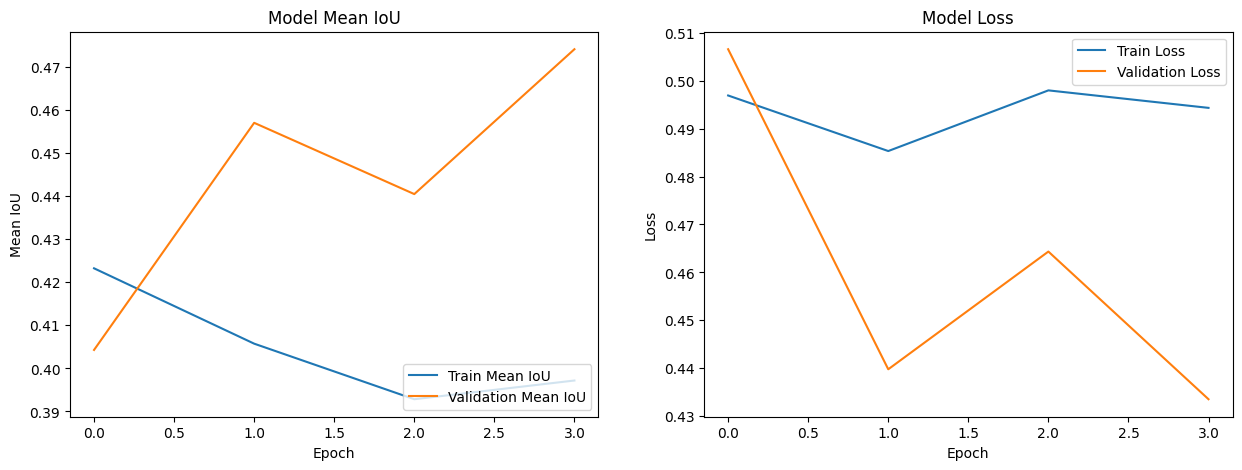

In [ ]:
# Plot creation with 2 subplots: (1 line, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Left Graph : Metric (Mean IoU in this case)
axs[0].plot(model_history.history['mean_io_u'], label='Train Mean IoU')
axs[0].plot(model_history.history['val_mean_io_u'], label='Validation Mean IoU')
axs[0].set_title('Model Mean IoU')
axs[0].set_ylabel('Mean IoU')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='lower right')

# Right Graph : Loss (Dice Loss in this case)
axs[1].plot(model_history.history['loss'], label='Train Loss')
axs[1].plot(model_history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper right')

# Plots display
plt.show()

# Model Saving

In [ ]:
unet_model.save(os.path.join(modelDir, modelName))